In [26]:
import copy
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from os.path import join as oj
from tqdm import tqdm

from imodels.importance import R2FExp, GeneralizedMDI, GeneralizedMDIJoint
from imodels.importance import LassoScorer, RidgeScorer, ElasticNetScorer, RobustScorer, LogisticScorer, JointRidgeScorer, JointLogisticScorer, JointRobustScorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
import shap
from feature_importance.scripts.mda import MDA

import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
DATA_DIR = "../../data"

In [17]:
X_df = pd.read_csv(oj(DATA_DIR, "X_tcga_var_filtered_log_transformed.csv"))
X = X_df.to_numpy()
y = pd.read_csv(oj(DATA_DIR, "Y_tcga.csv")).to_numpy().ravel()

In [18]:
X_df.head()

A2M      NAT1  RP11.986E7.7      AAMP      AARS      ABAT     ABCA2  \
0  9.614527  7.401763     10.859011  7.765291  7.625208  7.715826  7.500286   
1  8.725323  9.375599     10.128432  7.388699  7.658290  7.463426  7.031804   
2  8.671585  7.756825     10.690369  8.064953  7.976935  8.461162  7.444768   
3  9.339170  6.155162      7.340154  7.815608  8.993226  6.216886  6.922385   
4  8.909420  4.402246      8.196574  8.366875  7.949886  5.881482  8.076330   

      ABCA3     ABCF1      ABL1  ...  EIF3CL.1     PLIN4      MTPN     RELL1  \
0  6.677448  7.228231  7.572464  ...  9.237782  5.359995  8.073793  6.500534   
1  8.702240  7.566244  7.363025  ...  9.349586  6.583817  8.185900  6.551568   
2  8.378548  7.731562  7.365497  ...  9.417242  4.251032  8.359054  7.816944   
3  7.906770  8.111439  7.358005  ...  9.887913  4.239956  8.562925  7.082101   
4  7.432998  7.809034  7.864155  ...  9.525658  5.304333  8.157452  6.425711   

    SNHG8.1      OST4     TSTD1  GAGE12J.4    NBPF10  PRICKLE4.1  
0  6.411474  7.729637  7.369472   0.000000  6.609727    7.551117  
1  3.425952  7.161099  7.052134   0.000000  7.665767    7.310317  
2  5.631785  7.984734  7.587183   0.309101  6.425312    7.941761  
3  7.108862  7.414290  5.987086   0.000000  7.137403    7.841682  
4  6.033721  8.060675  7.341724   0.000000  6.776412    7.650708  

[5 rows x 5000 columns]

In [19]:
y

array(['LumA', 'LumB', 'LumA', ..., 'LumA', 'LumA', 'LumA'], dtype=object)

In [20]:
X.shape, y.shape

((1083, 5000), (1083,))

In [21]:
sorted(X_df.columns[X_df.columns.str.startswith("TP")])

['TP53',
 'TP53BP1',
 'TP53BP2',
 'TP53I11',
 'TP53INP1',
 'TP53INP2',
 'TPBG',
 'TPD52',
 'TPD52L1',
 'TPD52L2',
 'TPGS2',
 'TPI1',
 'TPM1',
 'TPM2',
 'TPM3',
 'TPM4',
 'TPP1',
 'TPPP3',
 'TPR',
 'TPRG1',
 'TPRN',
 'TPSAB1',
 'TPSB2',
 'TPT1',
 'TPX2']

## gjMDI Ridge

In [8]:
%%time
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt")
scorer = JointRidgeScorer(criterion="gcv", metric="loocv")
gjMDI_obj = GeneralizedMDIJoint(rf_model, scorer=scorer, normalize_raw=True, random_state=331)
imp_values, scores, class_scores, n_stumps, n_stumps_chosen = gjMDI_obj.get_importance_scores(X, y, diagnostics=True)

CPU times: user 2min 58s, sys: 15.1 s, total: 3min 13s
Wall time: 1min 29s


In [9]:
pd.DataFrame({"feature": X_df.columns, "importance": imp_values}).sort_values("importance", ascending=False).head()

feature  importance
626     ESR1   -0.642438
3114    TPX2   -0.645862
885    FOXA1   -0.648833
3167  TBC1D9   -0.652081
1449    PLK1   -0.652690

In [10]:
pd.DataFrame({"feature": X_df.columns, "importance": imp_values}).sort_values("importance", ascending=False).tail()

feature  importance
2399       CLDN8   -0.673016
115         ARF1   -0.673168
3310       PATZ1   -0.673296
2332        NAPA   -0.674194
4999  PRICKLE4.1        -inf

In [11]:
%%time
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt")
scorer = JointRidgeScorer(criterion="gcv", metric="loocv")
gjMDI_obj = GeneralizedMDIJoint(rf_model, scorer=scorer, normalize_raw=True, random_state=331)
imp_values, scores, class_scores_dict, n_stumps, n_stumps_chosen = gjMDI_obj.get_importance_scores(X, y, diagnostics=True)

CPU times: user 2min 59s, sys: 19.3 s, total: 3min 19s
Wall time: 2min 8s


In [12]:
pd.DataFrame({"feature": X_df.columns, "importance": imp_values}).sort_values("importance", ascending=False)

feature  importance
626         ESR1   -0.647087
885        FOXA1   -0.648013
3114        TPX2   -0.649989
2873       SPAG5   -0.652352
4798        AGR3   -0.652657
...          ...         ...
2144       PCGF2   -0.670386
2190       MFAP5   -0.670780
3977        EMC3   -0.673085
4374       ACSF2   -0.676452
4999  PRICKLE4.1        -inf

[5000 rows x 2 columns]

In [13]:
scores.shape

(100, 5000)

In [14]:
class_scores.shape

(500000, 7)

In [15]:
class_scores.head()

tree  feature     Basal      Her2      LumA      LumB   Normal
0     0        0 -0.615815 -2.242677 -0.000026 -0.667361 -5.79328
1     0        1 -0.615815 -2.242677 -0.000026 -0.667361 -5.79328
2     0        2 -0.615815 -2.242677 -0.000026 -0.667361 -5.79328
3     0        3 -0.615815 -2.242677 -0.000026 -0.667361 -5.79328
4     0        4 -0.615815 -2.242677 -0.000026 -0.667361 -5.79328

In [16]:
mean_class_scores = class_scores.groupby("feature").agg("mean")
mean_class_scores.head()

tree     Basal      Her2      LumA      LumB    Normal
feature                                                        
0        49.5 -0.766460 -2.623460 -0.002738 -0.590855 -6.241436
1        49.5 -0.766367 -2.627025 -0.000072 -0.591688 -6.251833
2        49.5 -0.766696 -2.622243 -0.002366 -0.590937 -6.241760
3        49.5 -0.766460 -2.623460 -0.002738 -0.590855 -6.241436
4        49.5 -0.766451 -2.623498 -0.002577 -0.590858 -6.241643

In [17]:
for class_idx, class_label in enumerate(gjMDI_obj.estimator.classes_):
    print(pd.DataFrame({"feature": X_df.columns, class_label: mean_class_scores[class_label]}).sort_values(class_label, ascending=False).reset_index(drop=True))

         feature     Basal
0          FOXA1 -0.705754
1           ESR1 -0.736357
2          SPDEF -0.740255
3         TBC1D9 -0.740627
4        CYP4Z2P -0.745063
...          ...       ...
4995        TXN2 -0.775833
4996        ARF1 -0.775835
4997       CLDN8 -0.775883
4998        NAPA -0.783126
4999  PRICKLE4.1       NaN

[5000 rows x 2 columns]
         feature      Her2
0           ESR1 -2.600328
1          ERBB2 -2.614414
2         STARD3 -2.614457
3           GRB7 -2.614764
4          SOX11 -2.617175
...          ...       ...
4995        NAPA -2.661129
4996       CLDN8 -2.668820
4997        ARF1 -2.669251
4998       PATZ1 -2.672111
4999  PRICKLE4.1       NaN

[5000 rows x 2 columns]
         feature      LumA
0           TPX2  0.021917
1           ESR1  0.019353
2           PLK1  0.013805
3          UBE2C  0.013803
4          FOXM1  0.011775
...          ...       ...
4995       GSTP1 -0.003439
4996       KRT16 -0.003710
4997       FOXC1 -0.004495
4998       GABRP -0.004525
4999 

## gjMDI Ridge with Stability Analysis

In [18]:
N_REPS = 10
METRIC = "loocv"

In [19]:
imp_values_dict = {}
class_scores_dict = {}
for rep in tqdm(range(N_REPS)):
    rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt",
                                      random_state=rep)
    scorer = JointRidgeScorer(criterion="gcv", metric="loocv")
    gjMDI_obj = GeneralizedMDIJoint(rf_model, scorer=scorer, normalize_raw=True, random_state=331)
    imp_values, _, class_scores, _, _ = gjMDI_obj.get_importance_scores(X, y, diagnostics=True)
    imp_values_dict[rep] = copy.deepcopy(imp_values)
    class_scores_dict[rep] = copy.deepcopy(class_scores.drop("tree", axis=1).\
                                           groupby("feature").agg("mean").reset_index())

100%|██████████| 10/10 [24:25<00:00, 146.56s/it]


In [20]:
imp_values_df = pd.DataFrame.from_dict(imp_values_dict)
imp_values_df.columns = ["rep{}".format(i) for i in range(imp_values_df.shape[1])]

In [21]:
from plotnine import ggplot, aes, geom_boxplot, geom_point, theme

In [22]:
imp_values_df.head()

rep0      rep1      rep2      rep3      rep4      rep5      rep6  \
0 -0.665831 -0.661924 -0.664784 -0.664343 -0.664893 -0.663706 -0.665791   
1 -0.662533 -0.658207 -0.662146 -0.663204 -0.660136 -0.659563 -0.661736   
2 -0.665673 -0.661365 -0.664121 -0.664184 -0.663576 -0.662804 -0.665021   
3 -0.665830 -0.671683 -0.664665 -0.664618 -0.664970 -0.663535 -0.667354   
4 -0.665830 -0.661445 -0.664666 -0.664202 -0.664082 -0.663535 -0.665502   

       rep7      rep8      rep9  
0 -0.662762 -0.664317 -0.666209  
1 -0.657861 -0.660137 -0.662083  
2 -0.662597 -0.663906 -0.666189  
3 -0.662751 -0.664128 -0.668491  
4 -0.662508 -0.664725 -0.665935

In [23]:
sns.pairplot(imp_values_df)

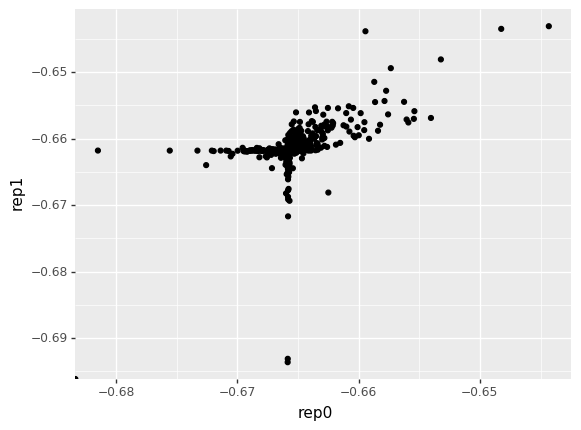

<ggplot: (8775731446381)>

In [24]:
ggplot(imp_values_df) +\
    aes(x="rep0", y="rep1") +\
    geom_point()

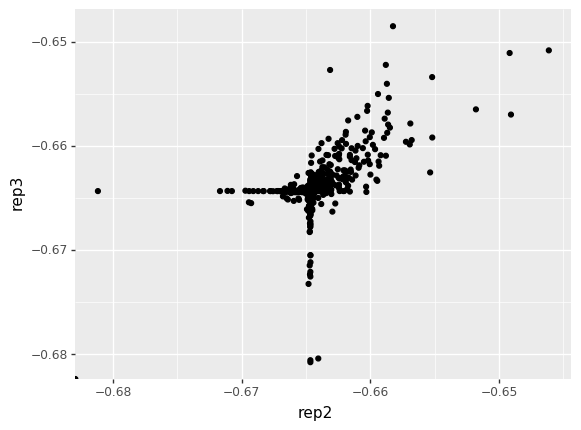

<ggplot: (8775668078205)>

In [25]:
ggplot(imp_values_df) +\
    aes(x="rep2", y="rep3") +\
    geom_point()

## Debugging permutation importance

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt",
                                  random_state=1)
rf_model.fit(X, y)

RandomForestClassifier(max_features='sqrt', random_state=1)

In [11]:
%%time
perm_fit = permutation_importance(rf_model, X, y, n_repeats=10, random_state=0)

CPU times: user 44min 31s, sys: 2min 48s, total: 47min 20s
Wall time: 48min 56s


In [12]:
perm_fit.importances.shape

(5000, 10)

In [13]:
perm_fit.importances_mean

array([0., 0., 0., ..., 0., 0., 0.])

In [14]:
perm_fit.importances_mean.max()

0.0

In [15]:
rf_model.score()

<bound method ClassifierMixin.score of RandomForestClassifier(max_features='sqrt', random_state=1)>

In [10]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt",
                                  random_state=1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', random_state=1)

In [11]:
%%time
perm_fit = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=0)

CPU times: user 15min 15s, sys: 12.1 s, total: 15min 28s
Wall time: 15min 47s


In [20]:
%%time
tree_perm_fit = permutation_importance(rf_model.estimators_[0], X_test, y_test, n_repeats=10, random_state=0)

CPU times: user 2min 55s, sys: 8.23 s, total: 3min 3s
Wall time: 3min 12s


In [ ]:
tree_perm_fit.importances_mean

In [21]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt",
                                  random_state=1)
rf_model.fit(X, y)

RandomForestClassifier(max_features='sqrt', random_state=1)

In [27]:
from sklearn.ensemble._forest import _generate_unsampled_indices
tree_perm_fits = {}
for tree_id, estimator in tqdm(enumerate(rf_model.estimators_)):
    oob_indices = _generate_unsampled_indices(estimator.random_state, X.shape[0], X.shape[0])
    tree_perm_fit = permutation_importance(estimator, X[oob_indices], y[oob_indices], n_repeats=10, random_state=tree_id)
    tree_perm_fits[tree_id] = tree_perm_fit

6it [25:28, 254.71s/it]


KeyboardInterrupt: 

In [18]:
perm_fit.importances.shape

(5000, 10)

In [12]:
perm_fit.importances_mean.max()

0.007541899441340838

In [13]:
perm_fit.importances_mean

array([-0.00027933,  0.00670391,  0.        , ...,  0.        ,
        0.00027933,  0.        ])

In [17]:
pd.DataFrame({"feature": X_df.columns, "importance": perm_fit.importances_mean}).sort_values("importance", ascending=False)

feature  importance
688     FOXM1    0.007542
3985   DBNDD2    0.007263
1        NAT1    0.006704
3531  RACGAP1    0.006145
4869   SERHL2    0.005587
...       ...         ...
4176   KLHL12   -0.002793
1184    MFGE8   -0.003073
3969    PRR11   -0.003352
3248    TENC1   -0.003911
2158    CSDE1   -0.004190

[5000 rows x 2 columns]

## Stability Analysis - gjMDI Ridge, MDI, Permutation

In [26]:
N_REPS = 10
METRIC = "loocv"

In [27]:
imp_values_dict = {}
class_scores_dict = {}
mdi_imp_values_dict = {}
perm_imp_values_dict = {}
for rep in tqdm(range(N_REPS)):
    rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt",
                                      random_state=rep)
    scorer = JointRidgeScorer(criterion="gcv", metric=METRIC)
    gjMDI_obj = GeneralizedMDIJoint(rf_model, scorer=scorer, normalize_raw=True, random_state=331)
    imp_values, _, class_scores, _, _ = gjMDI_obj.get_importance_scores(X, y, diagnostics=True)
    imp_values_dict[rep] = copy.deepcopy(imp_values)
    class_scores_dict[rep] = copy.deepcopy(class_scores.drop("tree", axis=1).\
                                           groupby("feature").agg("mean").reset_index())

    rf_model.fit(X, y)
    mdi_imp_values_dict[rep] = rf_model.feature_importances_

    # perm_fit = permutation_importance(rf_model, X, y, n_repeats=10, random_state=0)
    # perm_imp_values_dict[rep] = perm_fit.importances_mean


100%|██████████| 10/10 [26:25<00:00, 158.51s/it]


In [28]:
imp_values_df = pd.DataFrame.from_dict(imp_values_dict)
imp_values_df.columns = ["rep{}".format(i) for i in range(imp_values_df.shape[1])]
mdi_imp_values_df = pd.DataFrame.from_dict(mdi_imp_values_dict)
mdi_imp_values_df.columns = ["rep{}".format(i) for i in range(mdi_imp_values_df.shape[1])]
perm_imp_values_df = pd.DataFrame.from_dict(perm_imp_values_dict)
perm_imp_values_df.columns = ["rep{}".format(i) for i in range(perm_imp_values_df.shape[1])]

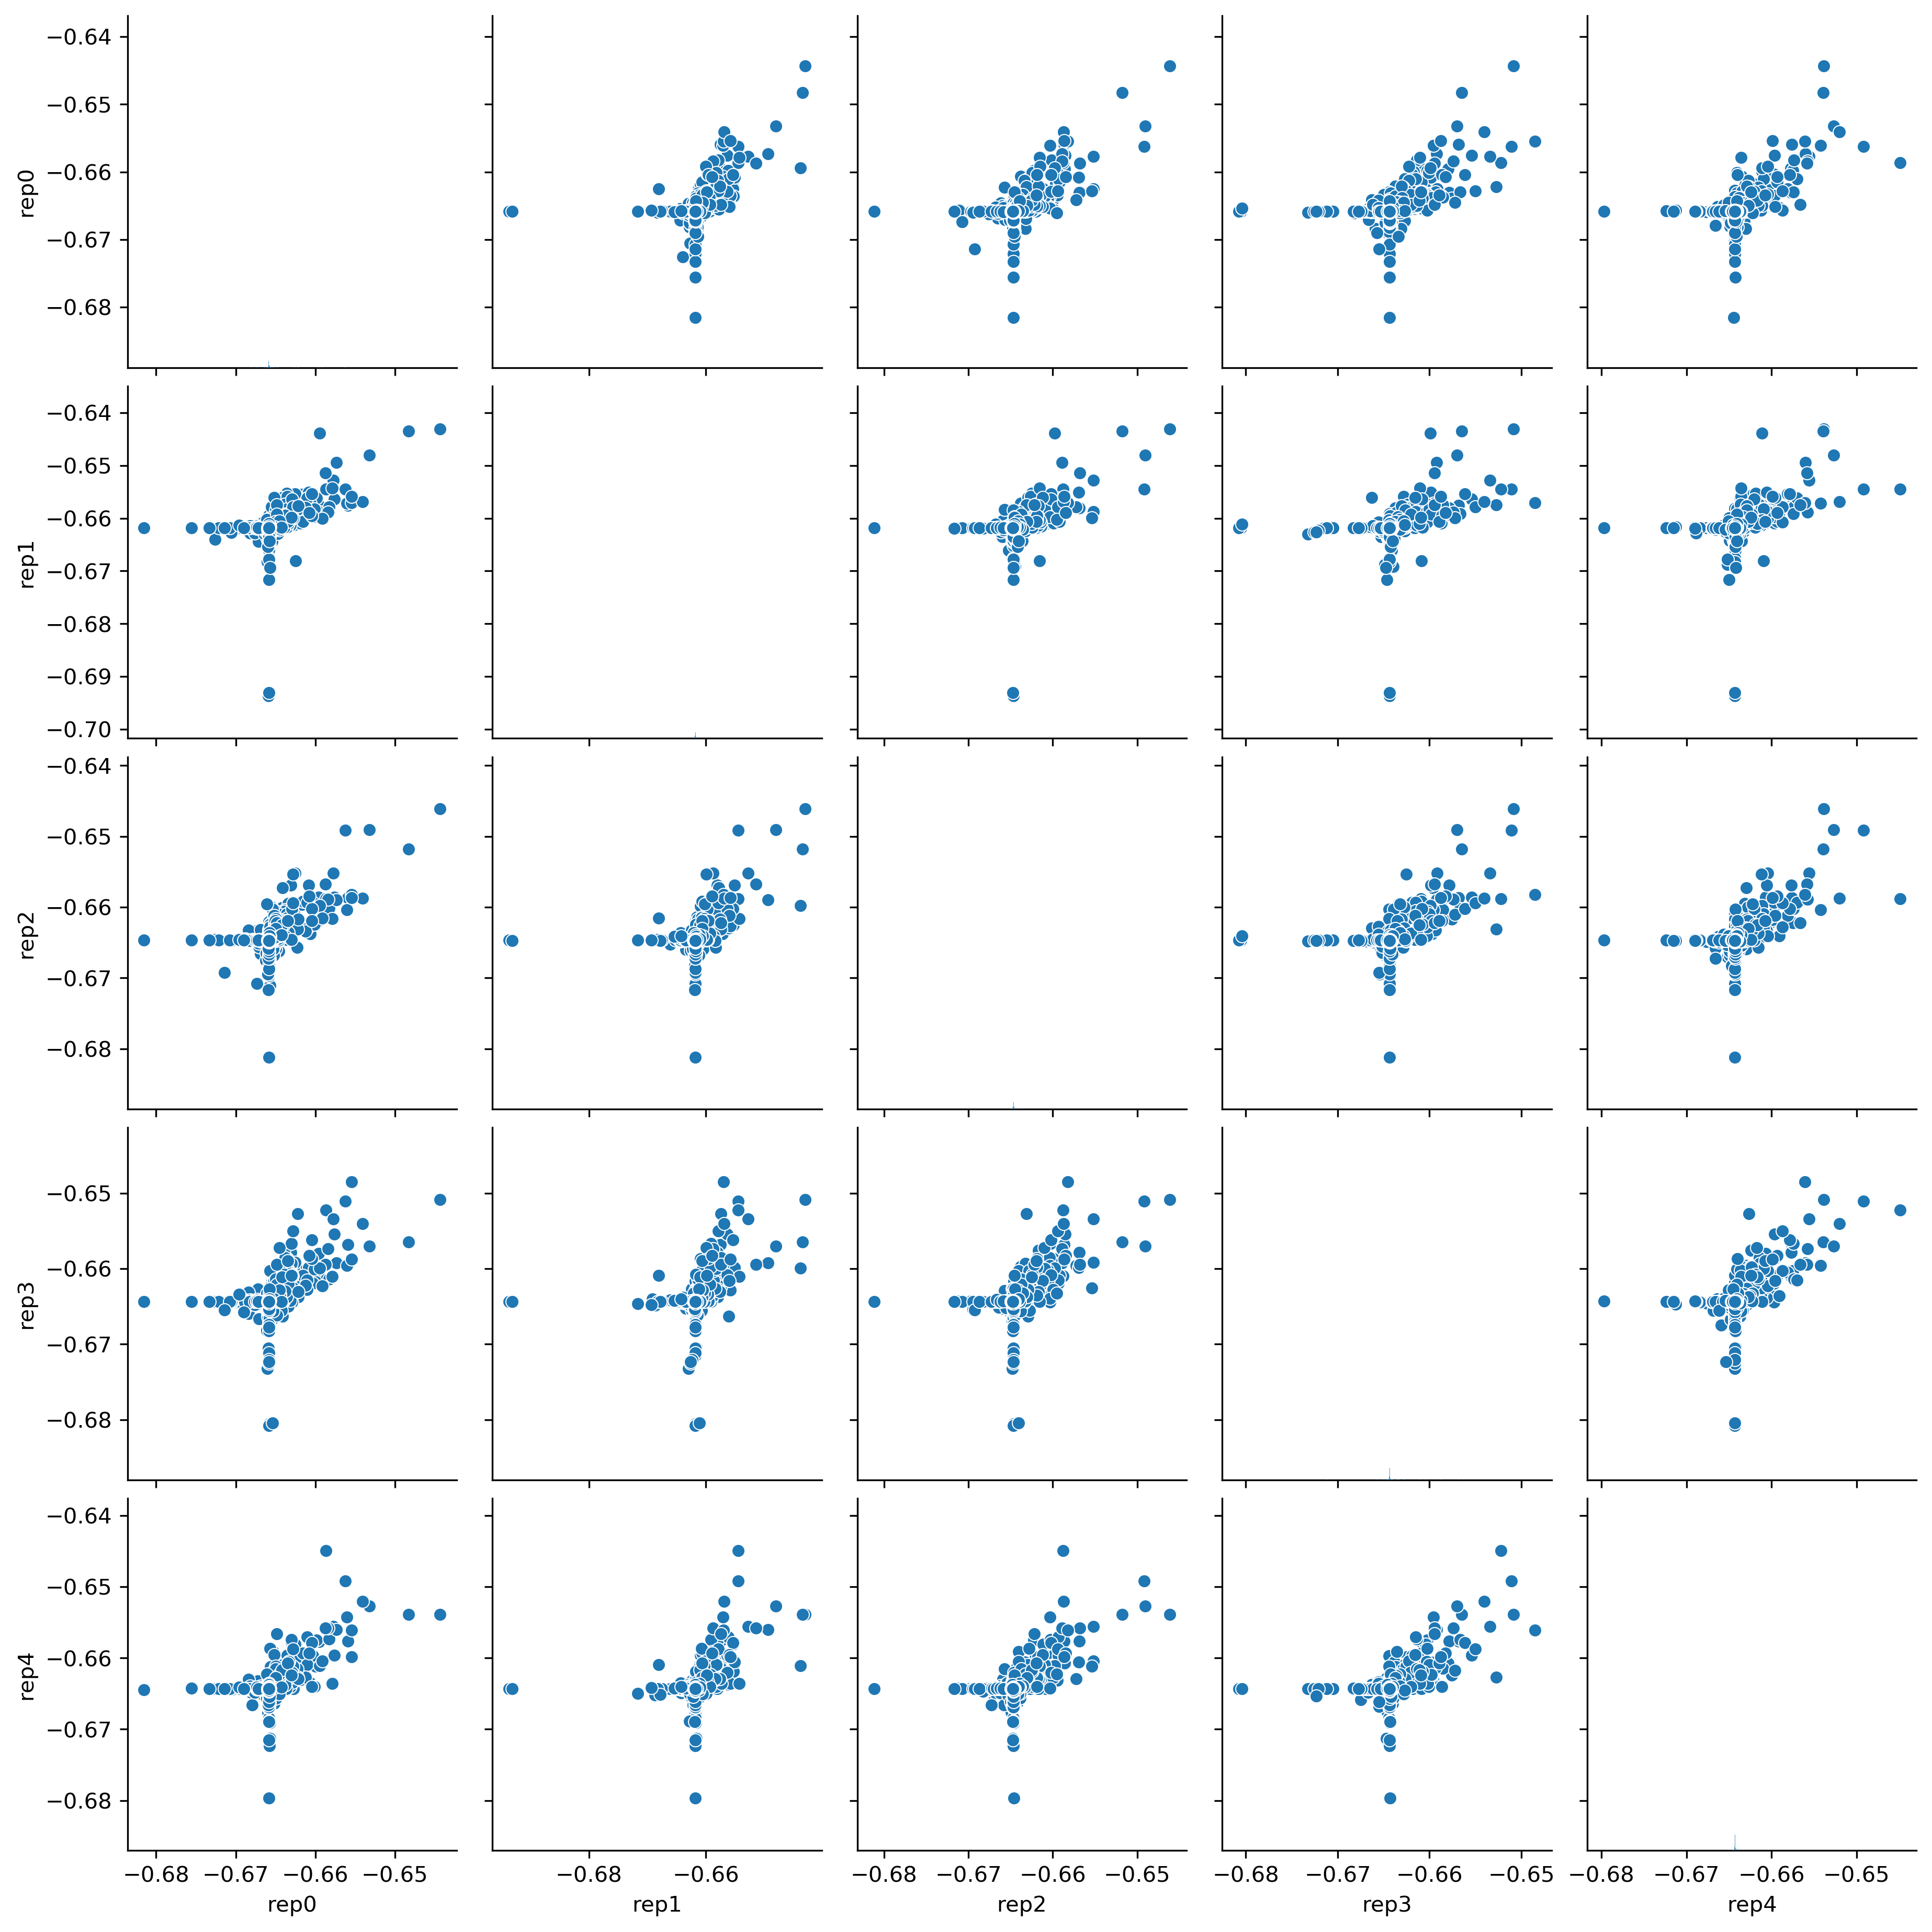

In [29]:
sns.pairplot(imp_values_df.iloc[:, :5])

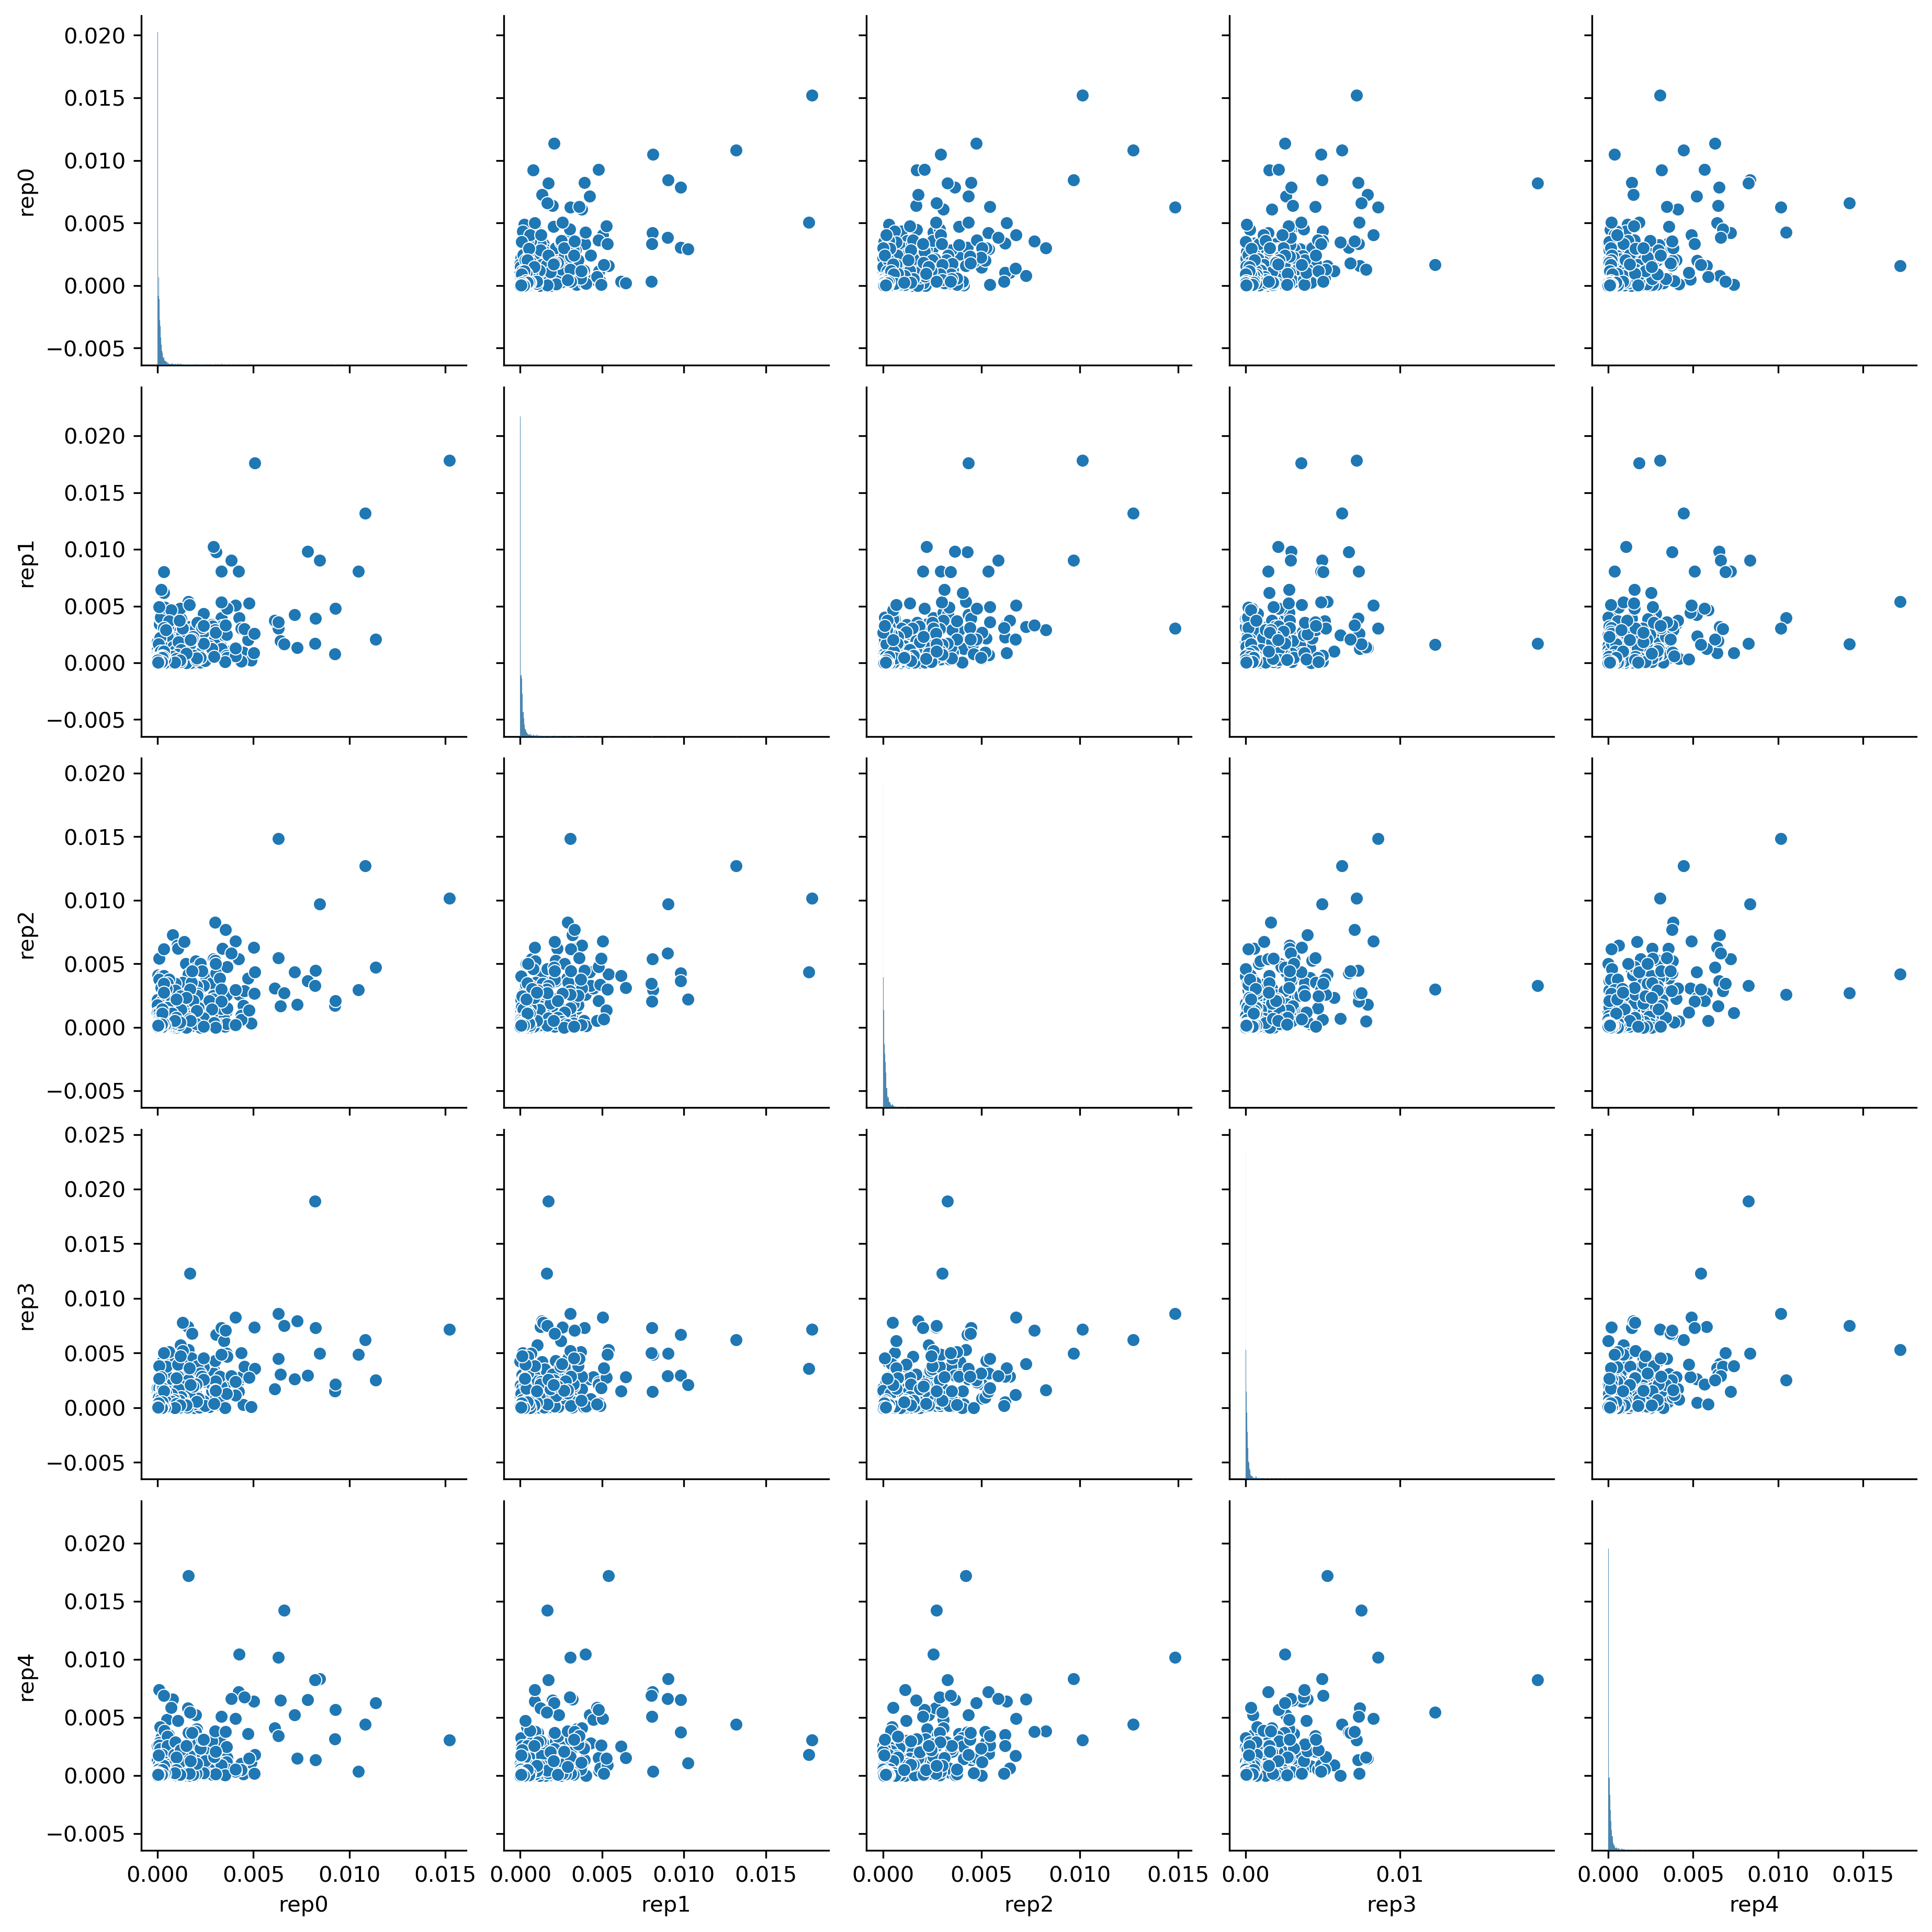

In [30]:
sns.pairplot(mdi_imp_values_df.iloc[:, :5])

In [31]:
# sns.pairplot(perm_imp_values_df.iloc[:, :5])

ValueError: No variables found for grid columns.

In [ ]:
method_comparison_df = pd.DataFrame({"gjMDI Ridge": imp_values_df["rep0"],
                                     "MDI": mdi_imp_values_df["rep0"]})
                                     #"Permutation": perm_imp_values_df["rep0"]})
sns.pairplot(method_comparison_df)

In [ ]:
perm_imp_values_df

In [ ]:
def isin_top_n(x, n=10):
    return x > x.sort_values(ascending=False).values[n]
gjmdi_top10 = pd.DataFrame({
    "feature": X_df.columns,
    "top10_prop": imp_values_df.apply(isin_top_n, axis=0).mean(axis=1)
})
mdi_top10 = pd.DataFrame({
    "feature": X_df.columns,
    "top10_prop": mdi_imp_values_df.apply(isin_top_n, axis=0).mean(axis=1)
})

In [ ]:
gjmdi_top10 = gjmdi_top10[gjmdi_top10["top10_prop"] > 0]
mdi_top10 = mdi_top10[mdi_top10["top10_prop"] > 0]

In [ ]:
gjmdi_top10.shape, mdi_top10.shape

In [ ]:
from plotnine import ggplot, aes, geom_bar

In [ ]:
gjmdi_top10.head()

In [ ]:
ax = sns.barplot(x="feature", y="top10_prop", data=gjmdi_top10,
                 order=gjmdi_top10.sort_values("top10_prop", ascending=False)["feature"])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

In [ ]:
ax = sns.barplot(x="feature", y="top10_prop", data=mdi_top10,
                 order=mdi_top10.sort_values("top10_prop", ascending=False)["feature"])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

## Try gjMDI with different metric

In [ ]:
import sklearn.metrics as metrics

In [ ]:
def multiclass_f1_score(y_onehot, ypreds, sample_weight=None):
    ypreds_label = ypreds.argmax(axis=1)
    y_label = y_onehot.argmax(axis=1)
    results = np.zeros(ypreds.shape[1])
    for k in range(ypreds.shape[1]):
        ypreds_k = (ypreds_label == k).astype(int)
        y_k = (y_label == k).astype(int)
        results[k] = metrics.f1_score(y_k, ypreds_k)
    return results

In [ ]:
N_REPS = 10
METRIC = multiclass_f1_score

In [ ]:
imp_values_dict2 = {}
class_scores_dict2 = {}
for rep in tqdm(range(N_REPS)):
    rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt",
                                      random_state=rep)
    scorer = JointRidgeScorer(criterion="gcv", metric=METRIC)
    gjMDI_obj = GeneralizedMDIJoint(rf_model, scorer=scorer, normalize_raw=True, random_state=331)
    imp_values, _, class_scores, _, _ = gjMDI_obj.get_importance_scores(X, y, diagnostics=True)
    imp_values_dict2[rep] = copy.deepcopy(imp_values)
    class_scores_dict2[rep] = copy.deepcopy(class_scores.drop("tree", axis=1).
                                            groupby("feature").agg("mean").reset_index())


In [ ]:
imp_values_df2 = pd.DataFrame.from_dict(imp_values_dict2)
imp_values_df2.columns = ["rep{}".format(i) for i in range(imp_values_df2.shape[1])]


In [ ]:
method_comparison_df = pd.DataFrame({#"gjMDI Ridge LOOCV": imp_values_df["rep0"],
                                     "gjMDI Ridge F1": imp_values_df2["rep0"],
                                     "feature": X_df.columns})
ggplot(method_comparison_df) +\
    aes(x="gjMDI Ridge LOOCV", y="gjMDI Ridge F1") +\
    geom_point()

In [ ]:
method_comparison_df.sort_values("gjMDI Ridge F1", ascending=False)

In [ ]:
gjmdi2_top10 = pd.DataFrame({
    "feature": X_df.columns,
    "top10_prop": imp_values_df2.apply(isin_top_n, axis=0).mean(axis=1)
})
gjmdi2_top10 = gjmdi2_top10[gjmdi2_top10["top10_prop"] > 0]

In [ ]:
gjmdi2_top10.shape

In [ ]:
subtype = "LumB"
pd.DataFrame({"feature": X_df.columns,
              "importance": class_scores.groupby("feature").agg("mean")[subtype]}).sort_values("importance", ascending=False)

In [ ]:
ax = sns.barplot(x="feature", y="top10_prop", data=gjmdi2_top10,
                 order=gjmdi2_top10.sort_values("top10_prop", ascending=False)["feature"])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

In [ ]:
len(np.intersect1d(gjmdi_top10["feature"], gjmdi2_top10["feature"]))

In [ ]:
np.intersect1d(gjmdi_top10["feature"], gjmdi2_top10["feature"])

## TreeSHAP

In [28]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)
shap_values
# results = abs(shap_values)
# results = results.mean(axis=0)

[array([[ 0.00000000e+00, -1.59318022e-03,  1.86607418e-04, ...,
          0.00000000e+00,  0.00000000e+00,  1.50582364e-05],
        [ 0.00000000e+00, -1.40116210e-03, -1.33419281e-04, ...,
          0.00000000e+00,  0.00000000e+00,  5.46925314e-06],
        [ 0.00000000e+00, -1.82008857e-03,  9.62073142e-05, ...,
          0.00000000e+00,  0.00000000e+00,  4.18760599e-06],
        ...,
        [ 0.00000000e+00, -1.65915445e-03,  2.26932561e-04, ...,
          0.00000000e+00,  0.00000000e+00,  6.43352107e-06],
        [ 0.00000000e+00, -1.16440651e-03,  4.10227742e-06, ...,
          0.00000000e+00,  0.00000000e+00,  4.98850857e-06],
        [ 0.00000000e+00, -1.35844630e-03, -9.67700176e-06, ...,
          0.00000000e+00,  0.00000000e+00,  5.47156640e-06]]),
 array([[ 5.59277855e-07, -4.51527065e-04, -8.07993085e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.94292409e-07, -6.78599604e-04, -2.83903673e-04, ...,
          0.00000000e+00,  0.00000000e

In [30]:
len(shap_values)

5

In [39]:
classes = rf_model.classes_
# classes = ["Basal", "LumA", "LumB", "Normal", "Her2"]

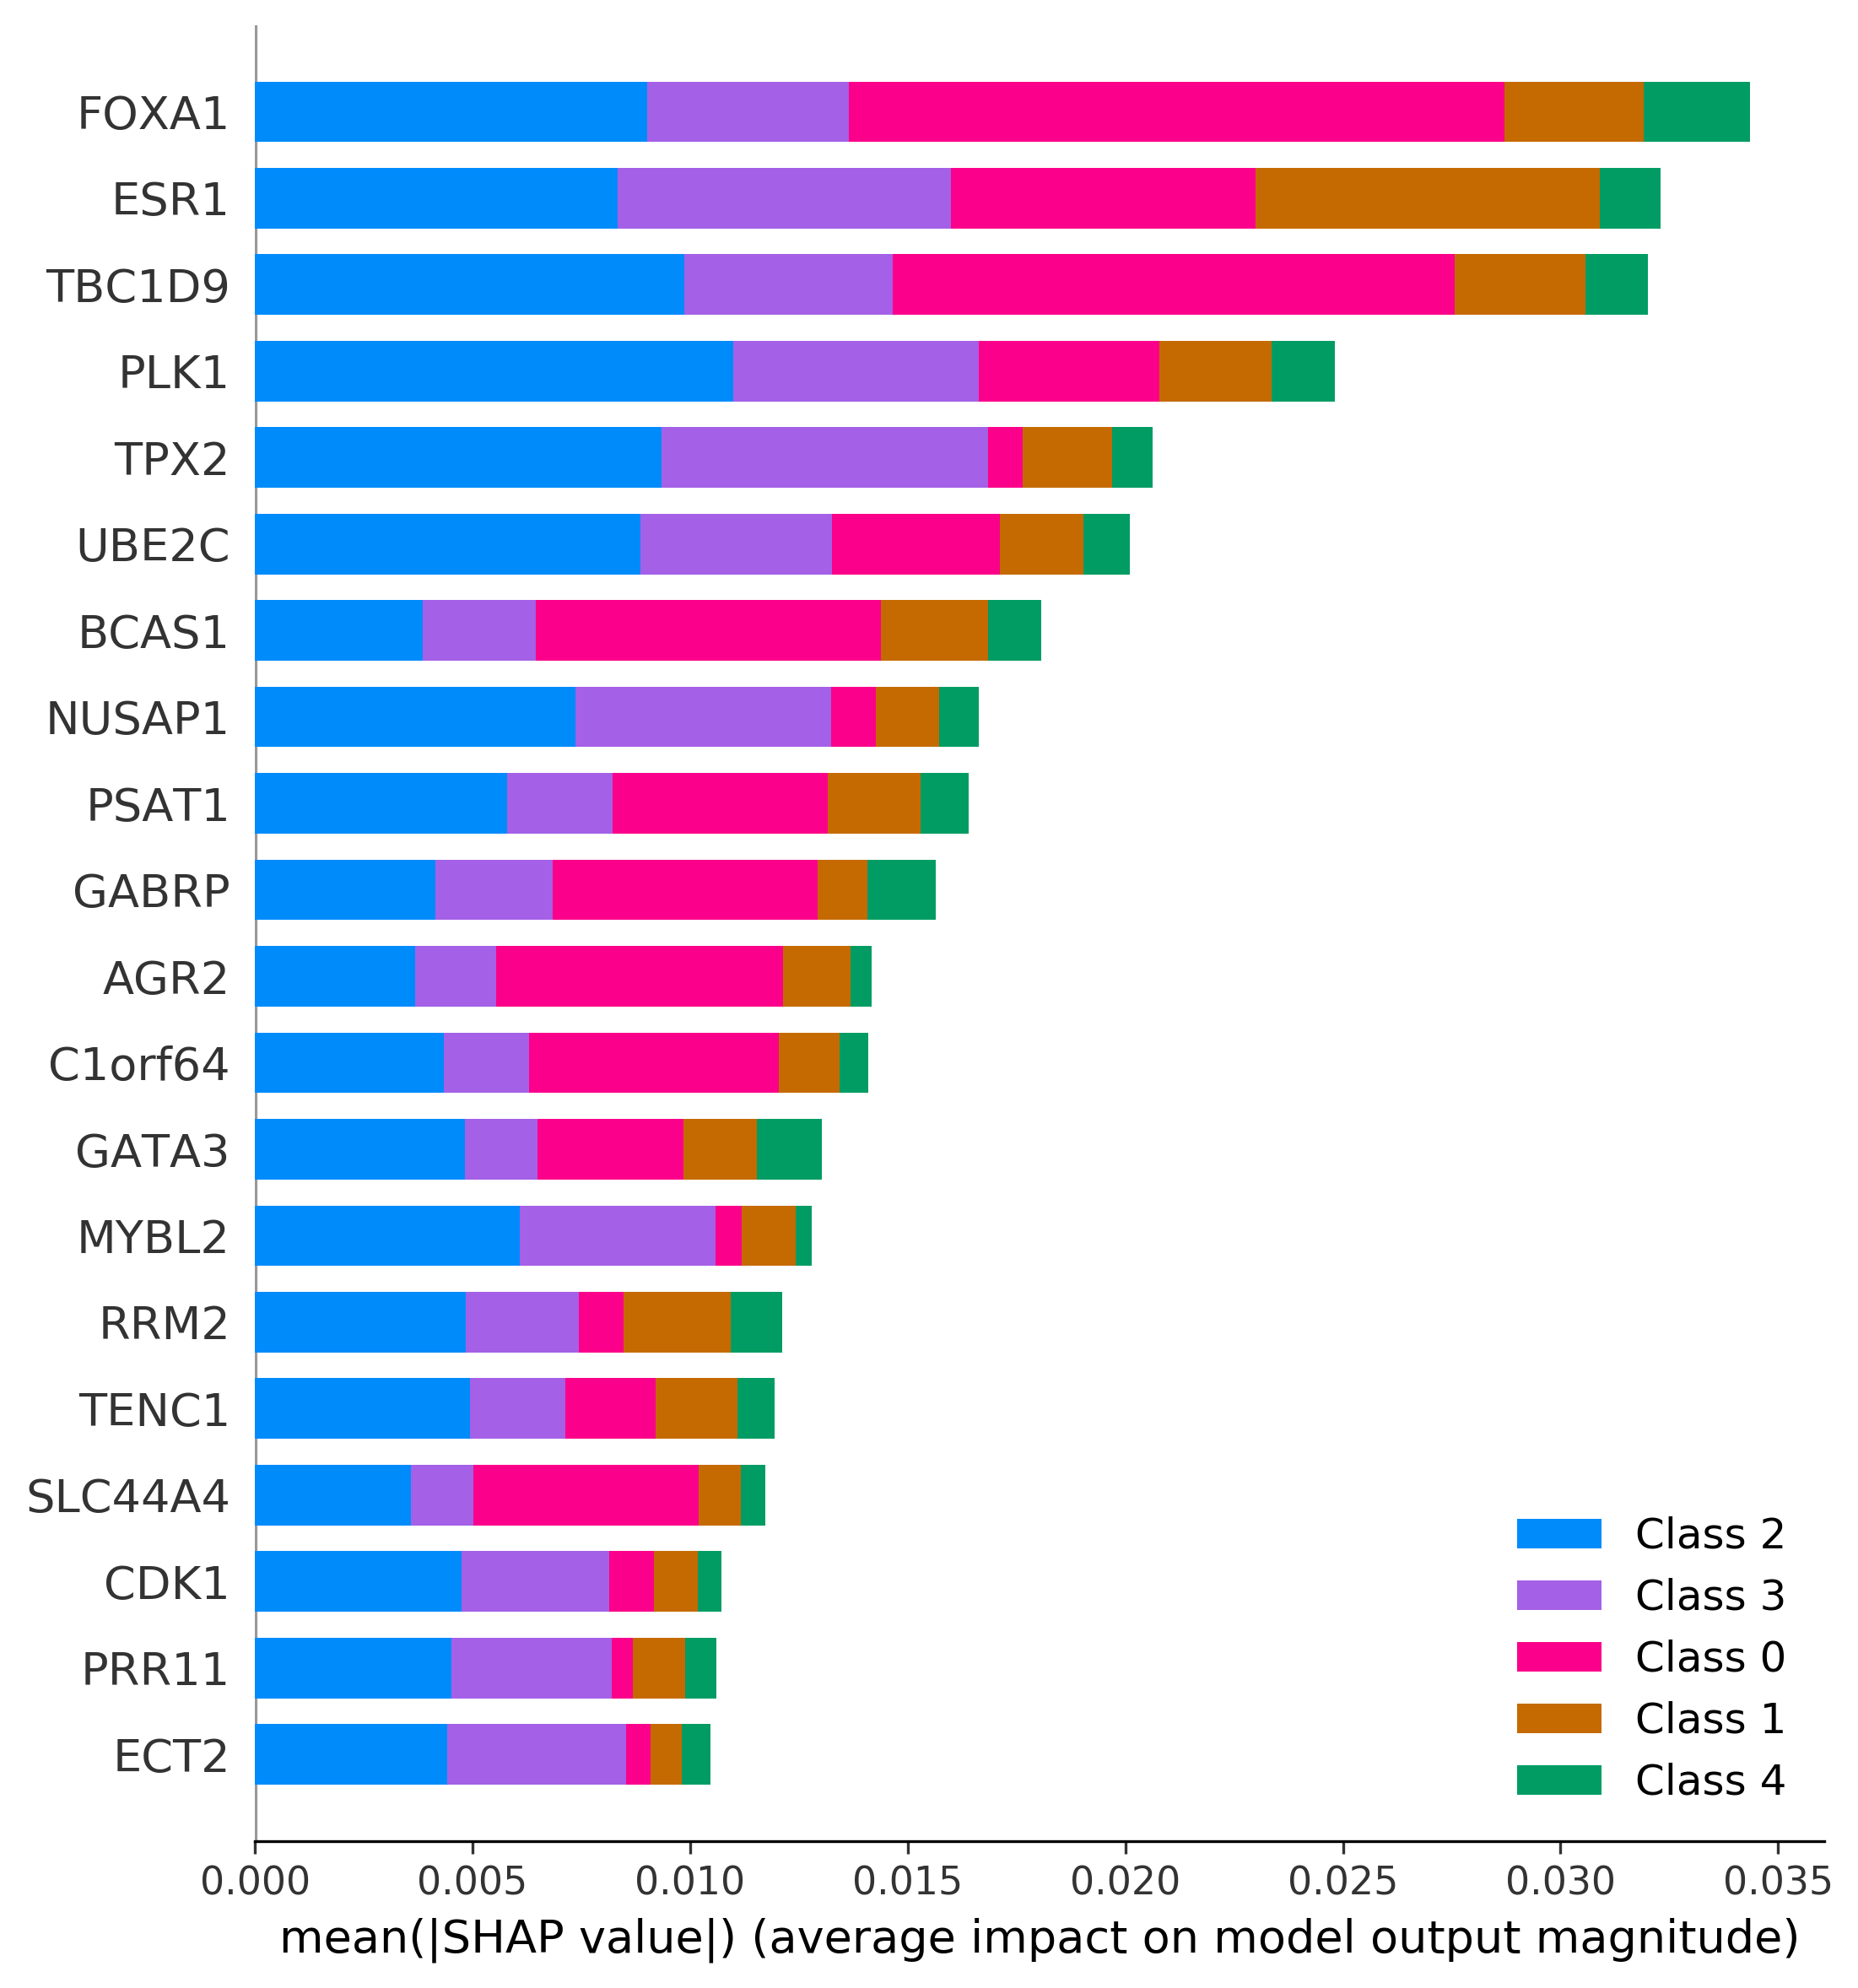

In [45]:
shap.summary_plot(shap_values, X_df.values, plot_type="bar", feature_names = X_df.columns)

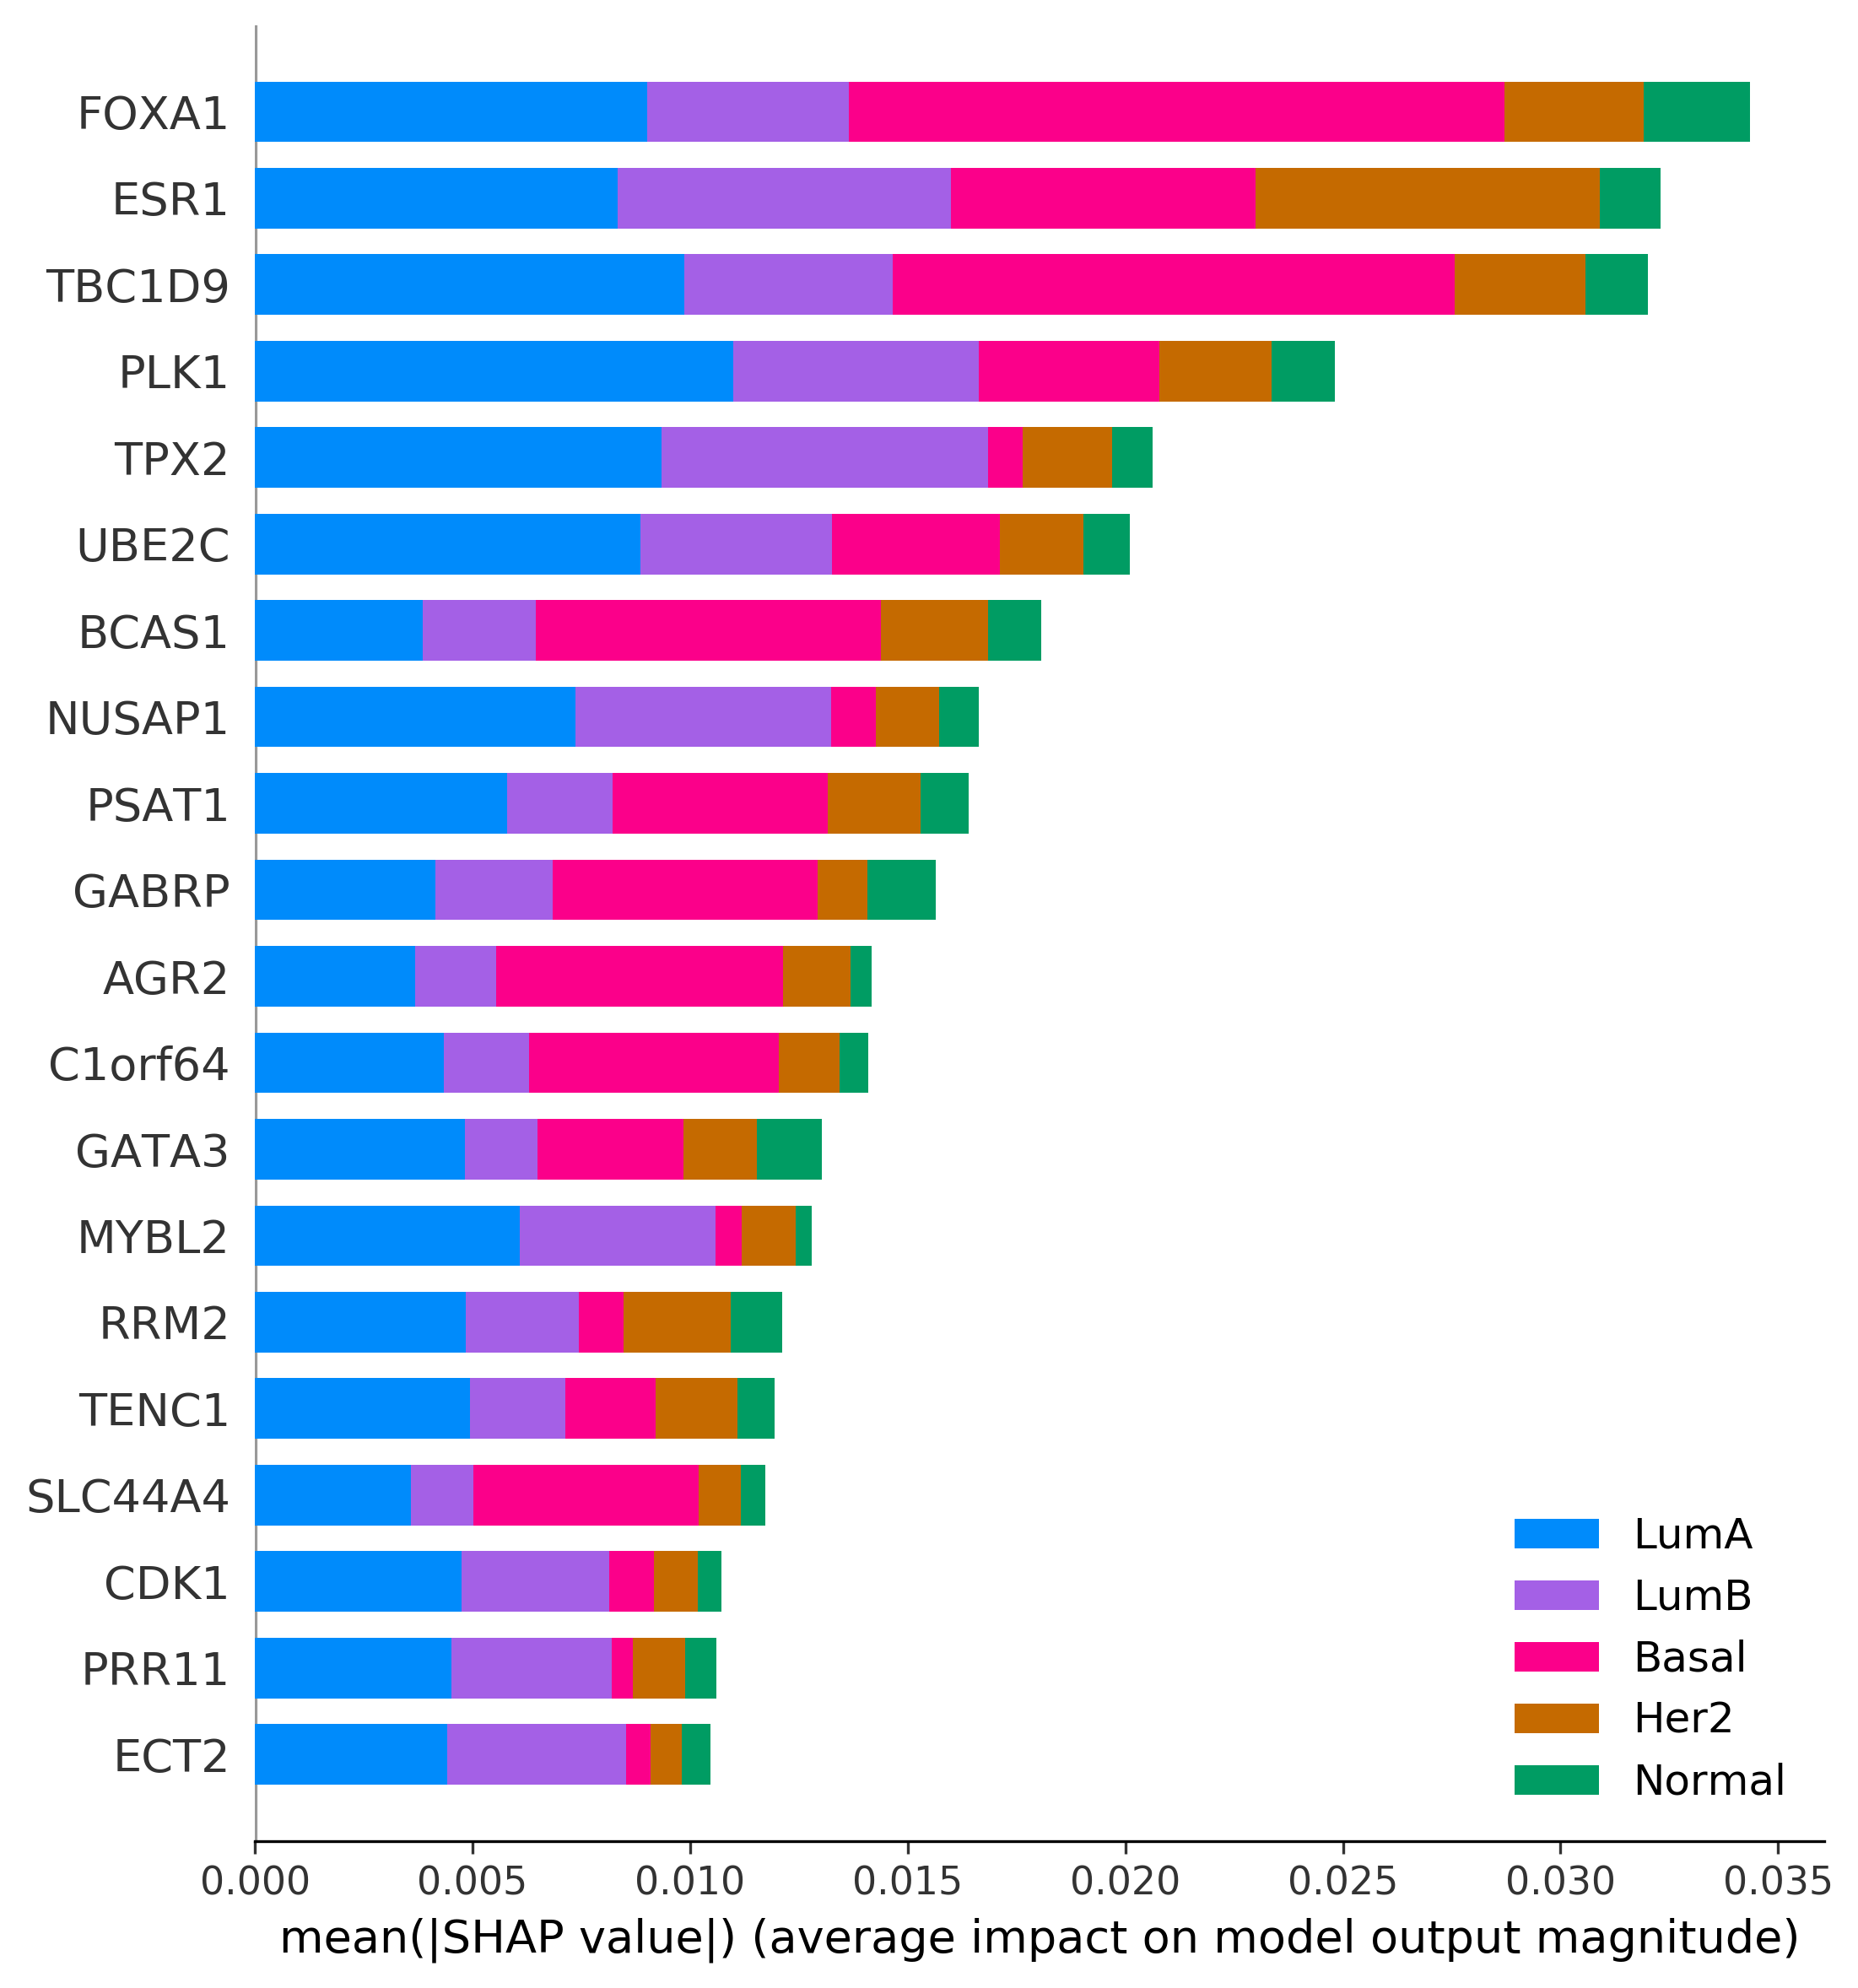

In [40]:
shap.summary_plot(shap_values, X_df.values, plot_type="bar", class_names= classes, feature_names = X_df.columns)

In [42]:
len(shap_values[1])

1083

In [44]:
shap_values[0].shape

(1083, 5000)

In [ ]:
np.abs(shap_values).mean(axis=0)

In [46]:
np.abs(shap_values[0]).mean(axis=0).shape

(5000,)

In [53]:
class_scores = pd.DataFrame({class_id: np.abs(shap_values[idx]).mean(axis=0) for idx, class_id in enumerate(rf_model.classes_)})
class_scores["feature"] = X_df.columns
# class_scores.sort_values("Basal", ascending=False).head()
class_scores.sort_values("LumA", ascending=False).head()

Basal      Her2      LumA      LumB    Normal feature
1449  0.004156  0.002578  0.010998  0.005631  0.001453    PLK1
3167  0.012919  0.002998  0.009873  0.004775  0.001445  TBC1D9
3114  0.000802  0.002060  0.009344  0.007492  0.000921    TPX2
885   0.015061  0.003210  0.009008  0.004637  0.002430   FOXA1
2999  0.003852  0.001920  0.008852  0.004411  0.001066   UBE2C

In [27]:
y_factorized = pd.factorize(y.ravel())
y_mda = y_factorized[0]
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=1)
rf_model.fit(X, y_mda)

RandomForestClassifier(max_features='sqrt', random_state=1)

In [10]:
rf_model.classes_

array([0, 1, 2, 3, 4])

In [11]:
rf_model.estimators_[0].classes_

array([0., 1., 2., 3., 4.])

In [29]:
%%time
mda_out, _ = MDA(rf_model, X, y_mda[:, np.newaxis], type="oob", n_trials=1, metric="accuracy")

100%|██████████| 5000/5000 [1:09:42<00:00,  1.20it/s]

CPU times: user 57min 15s, sys: 11min 37s, total: 1h 8min 52s
Wall time: 1h 9min 45s


In [30]:
%%time
mda_out2, _ = MDA(rf_model, X, y_mda[:, np.newaxis], type="oob", n_trials=10, metric="accuracy")

100%|██████████| 5000/5000 [11:32:55<00:00,  8.32s/it]

CPU times: user 9h 34min 3s, sys: 1h 56min 11s, total: 11h 30min 15s
Wall time: 11h 32min 57s


In [ ]:
%%time
mda_out3, _ = MDA(rf_model, X, y_mda[:, np.newaxis], type="oob", n_trials=5, metric="accuracy")

In [32]:
pd.DataFrame({"feature": X_df.columns,
              "importance": mda_out2}).sort_values("importance", ascending=False)

feature  importance
885     FOXA1    0.015594
3167   TBC1D9    0.014324
626      ESR1    0.013274
731     GATA3    0.007541
1449     PLK1    0.007217
...       ...         ...
140      ATF3   -0.000105
1845  SLC12A2   -0.000120
4750    SRXN1   -0.000126
4615   CADPS2   -0.000126
741     GCNT2   -0.000128

[5000 rows x 2 columns]

In [31]:
pd.DataFrame({"feature": X_df.columns,
              "importance": mda_out}).sort_values("importance", ascending=False)

feature  importance
885     FOXA1    0.016016
3167   TBC1D9    0.014635
626      ESR1    0.014258
3114     TPX2    0.007656
1449     PLK1    0.007230
...       ...         ...
1756   S100A6   -0.000151
741     GCNT2   -0.000151
1000    ITGB4   -0.000151
4801   FAM84B   -0.000176
1845  SLC12A2   -0.000201

[5000 rows x 2 columns]

## Stability Analysis

In [26]:
N_REPS = 10

In [ ]:
import sklearn.metrics as metrics

In [ ]:
def multiclass_f1_score(y_onehot, ypreds, sample_weight=None):
    ypreds_label = ypreds.argmax(axis=1)
    y_label = y_onehot.argmax(axis=1)
    results = np.zeros(ypreds.shape[1])
    for k in range(ypreds.shape[1]):
        ypreds_k = (ypreds_label == k).astype(int)
        y_k = (y_label == k).astype(int)
        results[k] = metrics.f1_score(y_k, ypreds_k)
    return results

In [27]:
gjmdi_loocv_imp_values_dict = {}
gjmdi_f1_imp_values_dict = {}
mdi_imp_values_dict = {}
# perm_imp_values_dict = {}
mda_imp_values_dict = {}
shap_imp_values_dict = {}

gjmdi_loocv_class_scores_dict = {}
gjmdi_f1_class_scores_dict = {}
shap_class_scores_dict = {}

for rep in tqdm(range(N_REPS)):
    rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=rep)
    loocv_scorer = JointRidgeScorer(criterion="gcv", metric="loocv")
    f1_scorer = JointRidgeScorer(criterion="gcv", metric=multiclass_f1_score)
    gjMDI_loocv = GeneralizedMDIJoint(copy.deepcopy(rf_model), scorer=loocv_scorer, normalize_raw=True, random_state=331)
    gjMDI_f1 = GeneralizedMDIJoint(copy.deepcopy(rf_model), scorer=f1_scorer, normalize_raw=True, random_state=331)

    imp_values, _, class_scores, _, _ = gjMDI_loocv.get_importance_scores(X, y, diagnostics=True)
    gjmdi_loocv_imp_values_dict[rep] = copy.deepcopy(imp_values)
    gjmdi_loocv_class_scores_dict[rep] = copy.deepcopy(class_scores.drop("tree", axis=1).\
                                                       groupby("feature").agg("mean").reset_index())

    imp_values, _, class_scores, _, _ = gjMDI_f1.get_importance_scores(X, y, diagnostics=True)
    gjmdi_f1_imp_values_dict[rep] = copy.deepcopy(imp_values)
    gjmdi_f1_class_scores_dict[rep] = copy.deepcopy(class_scores.drop("tree", axis=1).
                                                       groupby("feature").agg("mean").reset_index())

    rf_model.fit(X, y)
    mdi_imp_values_dict[rep] = rf_model.feature_importances_

    # perm_fit = permutation_importance(rf_model, X, y, n_repeats=10, random_state=0)
    # perm_imp_values_dict[rep] = perm_fit.importances_mean

    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X)
    class_scores = pd.DataFrame({class_id: np.abs(shap_values[idx]).mean(axis=0) for idx, class_id in enumerate(rf_model.classes_)})
    shap_imp_values_dict[rep] = copy.deepcopy(class_scores.mean(axis=1))
    class_scores["feature"] = X_df.columns
    shap_class_scores_dict[rep] = copy.deepcopy(class_scores)

    y_factorized = pd.factorize(y.ravel())
    y_mda = y_factorized[0]
    rf_model_mda = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=1)
    rf_model_mda.fit(X, y_mda)
    mda_out, _ = MDA(rf_model_mda, X, y_mda[:, np.newaxis], type="oob", n_trials=10, metric="accuracy")
    mda_imp_values_dict[rep] = copy.deepcopy(mda_out)

100%|██████████| 10/10 [26:25<00:00, 158.51s/it]
